In [193]:
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from tqdm import *
import os
from rdkit.Chem import AllChem
from rdkit import Chem
import glob

%matplotlib inline

#### Data processing

In [194]:
active_files = ["data/Sodium__and_chloride_dependent_glycine_transporter_1.txt", "data/Sodium__and_chloride_dependent_glycine_transporter_2.txt"]
decoy_dirs = ["Decoys_3_files/decoys_Sodium_chlor_deped_gly_trasp1/", "Decoys_3_files/decoys_Sodium_chlor_deped_gly_trasp2/"]

In [195]:
active_smiles = []
for file in active_files:
    with open(file, 'r') as f:
        smiles = [line.split('\t')[0] for line in f.readlines()]
        active_smiles.append(smiles)

In [196]:
decoy_smiles = []
for directory in decoy_dirs:
    files = glob.glob(directory + "decoys/*.picked")
    for file in files:
        with open(file, 'r') as f:
            smiles = [line.split('\t')[0] for line in f.readlines()]
            decoy_smiles.extend(smiles)

In [197]:
# Smiles that are in both the proteins
common = set(active_smiles[0]).intersection(set(active_smiles[1]))

In [198]:
smiles = []
smiles.append(list(set(active_smiles[0]) - common))
smiles.append(list(set(active_smiles[1]) - common))
smiles.append(list(common))
smiles.append(decoy_smiles)

In [283]:
len(smiles[0]), len(smiles[1]), len(smiles[2]), len(smiles[3])

(493, 51, 7, 29733)

In [199]:
def get_fp(smiles):
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    fps = []
    for mol in mols: # Weird for loop for tackling bad smiles!!
        try:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3)#, nBits=1024)
            fps.append(fp)
        except:
            continue
    fp_ar = np.array([[int(i) for i in fp.ToBitString()] for fp in fps], dtype=np.float32)
    return fp_ar

In [200]:
class_0_x = get_fp(smiles[0])
class_0_y = np.zeros(class_0_x.shape[0], dtype=np.int)
class_1_x = get_fp(smiles[1])
class_1_y = np.ones(class_1_x.shape[0], dtype=np.int)
class_2_x = get_fp(smiles[2])
class_2_y = np.ones(class_2_x.shape[0], dtype=np.int)*2
class_3_x = get_fp(smiles[3])
class_3_y = np.ones(class_3_x.shape[0], dtype=np.int)*3
data_x = np.vstack((class_0_x, class_1_x, class_2_x, class_3_x))
data_y = np.concatenate((class_0_y, class_1_y, class_2_y, class_3_y))

print(data_x.shape, data_y.shape)

(29701, 2048) (29701,)


#### Data Splitting

In [202]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, shuffle=True, stratify=data_y, test_size=0.3, random_state=1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((20790, 2048), (20790,), (8911, 2048), (8911,))

Now go to the NETWORK section

In [43]:
active_files = ["data/Sodium__and_chloride_dependent_glycine_transporter_1.txt", "data/Sodium__and_chloride_dependent_glycine_transporter_2.txt"]
decoy_dirs = ["Decoys_3_files/decoys_Sodium_chlor_deped_gly_trasp1/", "Decoys_3_files/decoys_Sodium_chlor_deped_gly_trasp2/"]

In [41]:
len(active_smiles[1])

58

In [3]:
def get_active_fp(file):
    protein_name = os.path.basename(file).split('.')[0]
    with open(file, 'r') as f:
        smiles = [line.split('\t')[0] for line in f.readlines()]
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    fps = []
    for mol in mols:
        try:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3)#, nBits=1024)
            fps.append(fp)
        except:
            continue
    fp_ar = np.array([[int(i) for i in fp.ToBitString()] for fp in fps], dtype=np.float32)
    return fp_ar

In [4]:
def get_decoy_fp(directory):
    files = glob.glob(directory + "decoys/*.picked")
    finger_prints = np.array([get_active_fp(f) for f in files], dtype=np.float32)
    
    return finger_prints.reshape((-1, 2048))

In [6]:
active_finger_prints = get_active_fp(active_files[0])
decoy_finger_prints = get_decoy_fp(decoy_dirs[0])
print(active_finger_prints.shape, decoy_finger_prints.shape)

(500, 2048) (24850, 2048)


In [7]:
# Label
data_x = np.vstack((active_finger_prints, decoy_finger_prints)).astype(np.float32)
data_y = np.concatenate((np.ones(active_finger_prints.shape[0]), np.zeros(decoy_finger_prints.shape[0]))).astype(np.int)
print(data_x.shape, data_y.shape)

(25350, 2048) (25350,)


### Data Splitting

In [10]:
# nb_classes = np.unique(data_y).shape[0]
# target = np_utils.to_categorical(data_y, nb_classes)
# print(target.shape, nb_classes)

In [11]:
# train_x, test_x, train_y, test_y = train_test_split(data_x, target, stratify=target, test_size=0.2, random_state=1)
# test_x, valid_x, test_y, valid_y = train_test_split(test_x, test_y, stratify=test_y, test_size=0.5, random_state=1)
# print(train_x.shape, train_y.shape, test_x.shape, test_y.shape, valid_x.shape, valid_y.shape)

In [12]:
# train_x = train_x.reshape(-1, 2048)
# test_x = test_x.reshape(-1, 2048)
# valid_x = valid_x.reshape(-1, 2048)
# train_x.shape, test_x.shape, valid_x.shape

In [237]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, stratify=data_y, test_size=0.2, random_state=1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((23760, 2048), (23760,), (5941, 2048), (5941,))

In [238]:
# Grid search for multiclass requires one-hot representation of y
train_y, test_y = label_binarize(train_y, classes=[0, 1, 2, 3]), label_binarize(test_y, classes=[0, 1, 2, 3])
print(train_y.shape, test_y.shape)

(23760, 4) (5941, 4)


### Networks

#### Random Forest

In [239]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, make_scorer, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [240]:
from sklearn.preprocessing import label_binarize

In [250]:
parameters = {'n_estimators':[i for i in range(100, 1000, 100)]}
# roc_auc returns error for highly unbalanced data because it requires all the classes to be present
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)} 
# scoring = {'accuracy': make_scorer(accuracy_score)} 
rfc = RandomForestClassifier(n_jobs=-1, class_weight='balanced', verbose=1)
clf = GridSearchCV(rfc, parameters, scoring=scoring, cv=4, refit='AUC', n_jobs=-1, verbose=1)

In [251]:
clf.fit(train_x, train_y)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  90 out of 100 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Done  90 out of 100 | elapsed:    2.8s remaining:    0.3s
[Parallel(n_jobs=56)]: Done  90 out of 100 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=56)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  90 out of 100 | elapsed:    2.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  90 out of 100 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=56)]: Done  90 out of 100 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=56)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=56)]: Done  90 out of 100 | elapsed:    0.4s remaining:    0.0s
[Parall

[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=56)]: Done 400 out of 400 | elapsed:    1.3s finished
[Parallel(n_jobs=56)]: Done 300 out of 300 | elapsed:    2.8s finished
[Parallel(n_jobs=56)]: Done 300 out of 300 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    7.6s
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   20.3s finished
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    6.4s
[Parallel(n_jobs=56)]: Done 300 out of 300 | elapsed:    2.0s finished
[Parallel(n_jobs=56)]: Done 400 out of 400 | elapsed:    1.4s finished
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.8s
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.6s
[Parallel(n_jobs=56)]: Done 300 out of 300 | elapsed:    2.5s finished
[Parallel(n_jobs=56)]: Done 400 out of 400 | elapsed:    1.6s finishe

[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    2.7s
[Parallel(n_jobs=56)]: Done 500 out of 500 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   15.1s
[Parallel(n_jobs=56)]: Done 600 out of 600 | elapsed:    4.2s finished
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   54.9s finished
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    8.9s
[Parallel(n_jobs=56)]: Done 600 out of 600 | elapsed:    2.2s finished
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.8s
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    1.3s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   52.5s finished
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=56)]: Do

[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   55.3s finished
[Parallel(n_jobs=56)]: Done 800 out of 800 | elapsed:    2.6s finished
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    1.5s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    2.1s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    3.0s
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.6s
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.7s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:    3.0s
[Parallel(n_jobs=56)]: Done 700 out of 700 | elapsed:    4.8s finished
[Parallel(n_jobs=56)]: Done 800 out of 800 | elapsed:    3.3s finished
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=56)]: Done 338 tasks      | elapsed:    1.7s
[Parallel(n_jobs=56)]: Done 688 tasks      | elapsed:    3.8s
[Parallel(n_jobs=56)]: Done 800 out of 800 | elapsed:    4.2s finished
[Parallel(n_jobs=56)]: Do

[Parallel(n_jobs=56)]: Done 900 out of 900 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    4.2s finished


GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=1, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)},
       verbose=1)

In [252]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_AUC',
 'mean_test_Accuracy',
 'mean_train_AUC',
 'mean_train_Accuracy',
 'param_n_estimators',
 'params',
 'rank_test_AUC',
 'rank_test_Accuracy',
 'split0_test_AUC',
 'split0_test_Accuracy',
 'split0_train_AUC',
 'split0_train_Accuracy',
 'split1_test_AUC',
 'split1_test_Accuracy',
 'split1_train_AUC',
 'split1_train_Accuracy',
 'split2_test_AUC',
 'split2_test_Accuracy',
 'split2_train_AUC',
 'split2_train_Accuracy',
 'split3_test_AUC',
 'split3_test_Accuracy',
 'split3_train_AUC',
 'split3_train_Accuracy',
 'std_fit_time',
 'std_score_time',
 'std_test_AUC',
 'std_test_Accuracy',
 'std_train_AUC',
 'std_train_Accuracy']

In [253]:
rf_model = clf.best_estimator_

In [254]:
rf_model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=1, warm_start=False)>

In [255]:
print(classification_report(train_y.argmax(axis=1), rf_model.predict(train_x).argmax(axis=1)))

[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.3s


             precision    recall  f1-score   support

          0       1.00      1.00      1.00       394
          1       1.00      1.00      1.00        41
          2       1.00      1.00      1.00         6
          3       1.00      1.00      1.00     23319

avg / total       1.00      1.00      1.00     23760



[Parallel(n_jobs=56)]: Done 300 out of 300 | elapsed:    0.7s finished


In [256]:
print(classification_report(test_y, rf_model.predict(test_x)))

[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.2s


             precision    recall  f1-score   support

          0       1.00      0.93      0.96        99
          1       1.00      0.90      0.95        10
          2       0.00      0.00      0.00         1
          3       1.00      1.00      1.00      5831

avg / total       1.00      1.00      1.00      5941



[Parallel(n_jobs=56)]: Done 300 out of 300 | elapsed:    0.5s finished
/home/mhassan/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [257]:
from sklearn.externals import joblib

In [259]:
filename = "random_forest_classifier_4_class"
joblib.dump(rf_model, filename)

['random_forest_classifier_4_class']

### NN from sklearn

In [260]:
from sklearn.neural_network import MLPClassifier

In [272]:
hidden_layer_sizes = [i for i in range(10, 200, 10)]

In [273]:
parameters = {'hidden_layer_sizes': hidden_layer_sizes}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

In [274]:
nn = MLPClassifier(solver='adam', alpha=1e-5, early_stopping=True, random_state=1, verbose=1)

In [275]:
# nn.fit(train_x, train_y)

In [276]:
clf = GridSearchCV(nn, 
                   parameters,
                   cv=4,
                   verbose=1,
                   scoring=scoring,
                   n_jobs=-1,
                   refit='AUC')

In [277]:
clf.fit(train_x, train_y)

Fitting 4 folds for each of 19 candidates, totalling 76 fits
Iteration 1, loss = 0.96488555
Validation score: 0.980920
Iteration 2, loss = 0.19301338
Validation score: 0.980920
Iteration 1, loss = 0.95635656
Validation score: 0.983726
Iteration 3, loss = 0.13470493
Validation score: 0.980920
Iteration 1, loss = 0.96030843
Validation score: 0.983726
Iteration 2, loss = 0.19718373
Validation score: 0.983726
Iteration 4, loss = 0.10186709
Validation score: 0.980920
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.97607081
Validation score: 0.988215
Iteration 2, loss = 0.19461212
Iteration 3, loss = 0.13685606
Validation score: 0.983726
Validation score: 0.983726
Iteration 1, loss = 0.74525443
Iteration 2, loss = 0.20130806
Validation score: 0.980359
Validation score: 0.988215
Iteration 4, loss = 0.10293823
Validation score: 0.983726
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stoppin

Validation score: 0.993266
Iteration 5, loss = 0.01154519
Iteration 9, loss = 0.00715803
Validation score: 0.998316
Iteration 4, loss = 0.01769841
Validation score: 0.997755
Validation score: 0.998878
Iteration 7, loss = 0.00565751
Validation score: 0.998878
Iteration 3, loss = 0.03141073
Validation score: 0.998878
Iteration 6, loss = 0.00701891
Iteration 8, loss = 0.00802368
Validation score: 0.999439
Validation score: 0.998878
Iteration 1, loss = 0.43935039
Validation score: 0.982043
Iteration 9, loss = 0.00718010
Validation score: 0.998878
Iteration 1, loss = 0.44241066
Iteration 7, loss = 0.00521121
Iteration 2, loss = 0.07542345
Validation score: 0.998878
Validation score: 0.981481
Validation score: 0.994388
Iteration 3, loss = 0.03222475
Iteration 8, loss = 0.00900066
Iteration 2, loss = 0.07930308
Validation score: 0.997194
Validation score: 0.997755
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Validation score: 0.993827
Iteration

Iteration 7, loss = 0.00468012
Validation score: 0.998878
Iteration 6, loss = 0.00493991
Iteration 7, loss = 0.00416093
Validation score: 0.998316
Validation score: 0.998878
Iteration 1, loss = 0.28305223
Validation score: 0.986532
Iteration 5, loss = 0.00763968
Validation score: 0.999439
Iteration 3, loss = 0.01745440
Iteration 9, loss = 0.00284446
Validation score: 0.999439
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.27296461
Validation score: 0.997194
Iteration 5, loss = 0.00868958
Validation score: 0.985410
Validation score: 0.998878
Iteration 5, loss = 0.00703643
Validation score: 0.998878
Iteration 13, loss = 0.00147928
Validation score: 0.999439
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 8, loss = 0.00269055
Validation score: 0.998316
Iteration 2, loss = 0.04821796
Iteration 7, loss = 0.00344823
Validation score: 0.993827
Validation score: 0.998316

Validation score: 0.996072
Iteration 4, loss = 0.00895706
Validation score: 0.993266
Iteration 6, loss = 0.00260778
Validation score: 0.998316
Validation score: 0.997755
Iteration 5, loss = 0.00469252
Validation score: 0.998878
Validation score: 0.998316
Iteration 2, loss = 0.03864903
Iteration 5, loss = 0.00414339
Validation score: 0.997755
Validation score: 0.998878
Iteration 4, loss = 0.00678257
Validation score: 0.999439
Iteration 1, loss = 0.23963784
Iteration 2, loss = 0.04074075
Iteration 6, loss = 0.00305825
Iteration 7, loss = 0.00371683
Validation score: 0.994949
Validation score: 0.995511
Validation score: 0.990460
Validation score: 0.997755
Iteration 4, loss = 0.00763948
Validation score: 0.997755
Iteration 1, loss = 0.24776024
Iteration 3, loss = 0.01466981
Iteration 1, loss = 0.23455516
Validation score: 0.993266
Iteration 5, loss = 0.00596860
Iteration 2, loss = 0.04093330
Iteration 1, loss = 0.23955410
Validation score: 0.997194
Validation score: 0.998316
Iteration 5, l

Validation score: 0.998878
Iteration 3, loss = 0.01038234
Iteration 9, loss = 0.00112558
Iteration 3, loss = 0.01108175
Iteration 7, loss = 0.00173416
Iteration 8, loss = 0.00157145
Validation score: 0.997194
Validation score: 0.997755
Validation score: 0.998878
Validation score: 0.999439
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Validation score: 0.998878
Iteration 3, loss = 0.01119200
Iteration 6, loss = 0.00318733
Iteration 7, loss = 0.00193904
Iteration 5, loss = 0.00527402
Validation score: 0.998878
Validation score: 0.998878
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Validation score: 0.999439
Iteration 4, loss = 0.00486179
Validation score: 0.997755
Iteration 9, loss = 0.00125666
Iteration 11, loss = 0.00140149
Validation score: 0.998316
Validation score: 0.997755
Validation score: 0.9

[Parallel(n_jobs=-1)]: Done  42 out of  76 | elapsed:   50.0s remaining:   40.5s


Iteration 9, loss = 0.00143936
Iteration 3, loss = 0.01009206
Validation score: 0.999439
Validation score: 0.997755
Iteration 8, loss = 0.00166168
Iteration 4, loss = 0.00583091
Validation score: 0.998316
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 4, loss = 0.00396990
Validation score: 0.998878
Validation score: 0.998316
Iteration 6, loss = 0.00237402
Validation score: 0.998878
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 4, loss = 0.00468340
Validation score: 1.000000
Iteration 6, loss = 0.00192629
Validation score: 0.998878
Iteration 9, loss = 0.00124560
Iteration 4, loss = 0.00552572
Validation score: 0.998878
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 7, loss = 0.00215040
Validation score: 0.998878
Validation score: 1.000000
Iteration 4, loss = 0.00493904
Iteration 6, loss = 0.00227568
Iteration 3, loss 

[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:  1.1min finished


Iteration 1, loss = 0.30448850
Validation score: 0.984428
Iteration 2, loss = 0.04319628
Validation score: 0.996212
Iteration 3, loss = 0.01556679
Validation score: 0.998316
Iteration 4, loss = 0.00750561
Validation score: 0.999579
Iteration 5, loss = 0.00450153
Validation score: 0.999579
Iteration 6, loss = 0.00292518
Validation score: 0.999158
Iteration 7, loss = 0.00206615
Validation score: 0.999158
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


GridSearchCV(cv=4, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=1,
       warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'hidden_layer_sizes': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)},
       verbose=1)

In [278]:
nn_model = clf.best_estimator_

In [279]:
nn_model.get_params

<bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=80, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=1,
       warm_start=False)>

In [284]:
cnf = confusion_matrix(test_y.argmax(axis=1), nn_model.predict(test_x).argmax(axis=1))

In [287]:
import itertools

In [306]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.tight_layout()
    plt.savefig('confusion.png', dpi=300)

Normalized confusion matrix
[[0.96969697 0.         0.         0.03030303]
 [0.2        0.7        0.         0.1       ]
 [1.         0.         0.         0.        ]
 [0.         0.         0.         1.        ]]


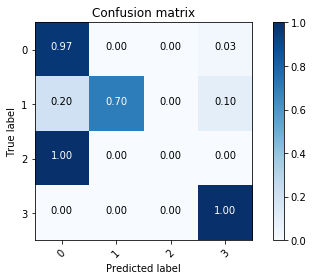

In [307]:
plot_confusion_matrix(cnf, classes=[0, 1, 2, 3], normalize=True)

In [318]:
report = classification_report(test_y.argmax(axis=1), nn_model.predict(test_x).argmax(axis=1))
print(report)

             precision    recall  f1-score   support

          0       0.97      0.97      0.97        99
          1       1.00      0.70      0.82        10
          2       0.00      0.00      0.00         1
          3       1.00      1.00      1.00      5831

avg / total       1.00      1.00      1.00      5941



/home/mhassan/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [320]:
from sklearn.metrics import roc_curve, auc

In [343]:
# Compute ROC curve and ROC area for each class
n_classes = 4
pred_y = nn_model.predict(test_x)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], pred_y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), pred_y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

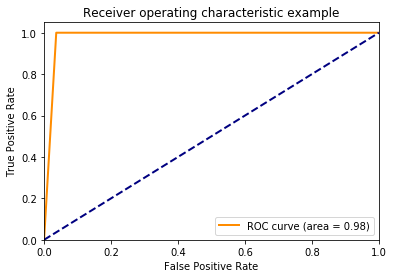

In [344]:
plt.figure()
lw = 2
cl = 3
plt.plot(fpr[cl], tpr[cl], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[cl])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [345]:
from scipy import interp
from itertools import cycle

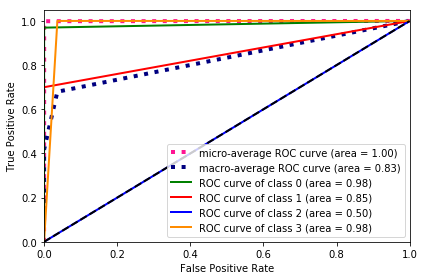

In [348]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['green', 'red', 'blue', 'darkorange',])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300)
plt.show()

In [282]:
filename = "nn_classifier_4_class"
joblib.dump(nn_model, filename)

['nn_classifier_4_class']